# Model Build

 


In [10]:
import numpy as np
import pandas as pd
import time

import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from numpy import count_nonzero

from typing import Dict, Text

In [11]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [12]:
# filter for is listened == 1

train_listened = train_df[train_df['is_listened'] == 1]
train_listened.reset_index(inplace=True, drop=True)

# only first 100'000 records
train_listened_small = train_listened.loc[:99999]
train_listened_small[['user_id', 'media_id']] = train_listened_small[['user_id', 'media_id']].astype(str)


/var/folders/48/hls1bn594jv01b8czjn52sp80000gn/T/ipykernel_36244/40870951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_listened_small[['user_id', 'media_id']] = train_listened_small[['user_id', 'media_id']].astype(str)


In [13]:
# convert to tfds datset

deezer_ratings = tf.data.Dataset.from_tensor_slices(dict(train_listened_small)).\
    map(lambda x: {
    'user_id': x['user_id'], 
    'is_listened': x['is_listened'], 
    'media_id': x['media_id'], 
    'timestamp': x['ts_listen']})

# get sample for overview
# for x in deezer_ratings.take(5).as_numpy_iterator():
#   print(x)

# assert correct object type
print(deezer_ratings)

<MapDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'is_listened': TensorSpec(shape=(), dtype=tf.int64, name=None), 'media_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'timestamp': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [14]:
tf.random.set_seed(42)
shuffled = deezer_ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(2_000)

In [15]:
songs = deezer_ratings.map(lambda x: x["media_id"])
user = deezer_ratings.map(lambda x: x["user_id"])

song_ids = deezer_ratings.batch(1_000_000).map(lambda x: x["media_id"])
user_ids = deezer_ratings.batch(1_000_000).map(lambda x: x["user_id"])

unique_song_ids = np.unique(np.concatenate(list(song_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))


In [16]:
# define user and item models

embedding_dimension = 32

# Compute embeddings for users.
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
    vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

# Compute embeddings for movies.
song_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
    vocabulary=unique_song_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_song_ids) + 1, embedding_dimension)
])

# get top k recommendations
metrics = tfrs.metrics.FactorizedTopK(
  candidates=song_ids.map(song_model)
)
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

In [17]:
class DeezerRecModel(tfrs.Model):

  def __init__(self, user_model, song_model):
    super().__init__()
    self.song_model = tf.keras.Model = song_model
    self.user_model: tf.keras.Model = user_model

    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    user_embeddings = self.user_model(features["user_id"])
    positive_song_embeddings = self.song_model(features["media_id"])
    return self.task(user_embeddings, positive_song_embeddings)

In [18]:
model = DeezerRecModel(user_model, song_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()
model.fit(cached_train, epochs=100)

Epoch 1/100
10/10 [==============================] - 43s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0010 - factorized_top_k/top_10_categorical_accuracy: 0.0010 - factorized_top_k/top_50_categorical_accuracy: 0.0032 - factorized_top_k/top_100_categorical_accuracy: 0.0071 - loss: 67268.0554 - regularization_loss: 0.0000e+00 - total_loss: 67268.0554      
Epoch 2/100
10/10 [==============================] - 43s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0230 - factorized_top_k/top_5_categorical_accuracy: 0.0230 - factorized_top_k/top_10_categorical_accuracy: 0.0231 - factorized_top_k/top_50_categorical_accuracy: 0.0367 - factorized_top_k/top_100_categorical_accuracy: 0.0542 - loss: 57950.4680 - regularization_loss: 0.0000e+00 - total_loss: 57950.4680
Epoch 3/100
10/10 [==============================] - 43s 4s/step - factorized_top_k/top_1_categorical_accuracy: 0.0503 - factorized_top_k/top_5_categorical_accu

In [19]:
results = model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 3s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.1080 - factorized_top_k/top_5_categorical_accuracy: 0.1220 - factorized_top_k/top_10_categorical_accuracy: 0.1455 - factorized_top_k/top_50_categorical_accuracy: 0.2010 - factorized_top_k/top_100_categorical_accuracy: 0.2390 - loss: 13646.0674 - regularization_loss: 0.0000e+00 - total_loss: 13646.0674


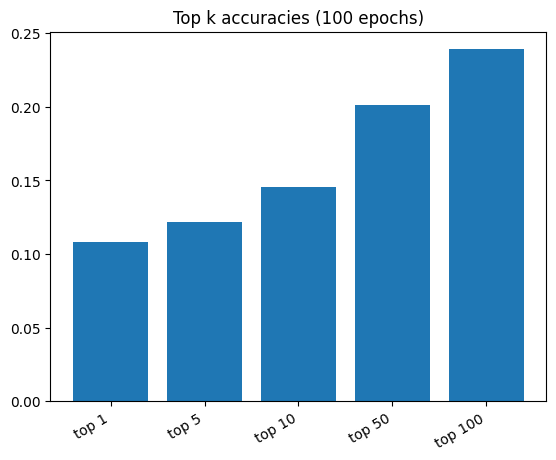

In [23]:
# show results
labels = []
[labels.append(f'top {i}') for i in [1, 5, 10, 50, 100]]

fig, ax = plt.subplots()
ax.bar(labels, list(results.values())[:5])
#ax.set_ylim([0.125, 0.23])
plt.xticks(rotation=30, ha='right')
plt.title('Top k accuracies (100 epochs)')
plt.savefig("../figures/top_k_accuracies.png")


In [21]:
# Recommendation for a single user
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
  tf.data.Dataset.zip((songs.batch(1000), songs.batch(1000).map(model.song_model)))
)

_, titles = index(tf.constant(["1387"]))
print(f"Song id Recommendations for user: {titles[0, :1]}")

Song id Recommendations for user: [b'14747633']


In [24]:
results.values()


dict_values([0.1080000028014183, 0.12200000137090683, 0.14550000429153442, 0.20100000500679016, 0.23899999260902405, 13646.0673828125, 0, 13646.0673828125])